## Compute Fundamental Matrix
To compute the fundamental matrix (F) using corresponding feature points from two stereo images and understand its role in epipolar geometry and 3D reconstruction in computer vision.

In [7]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

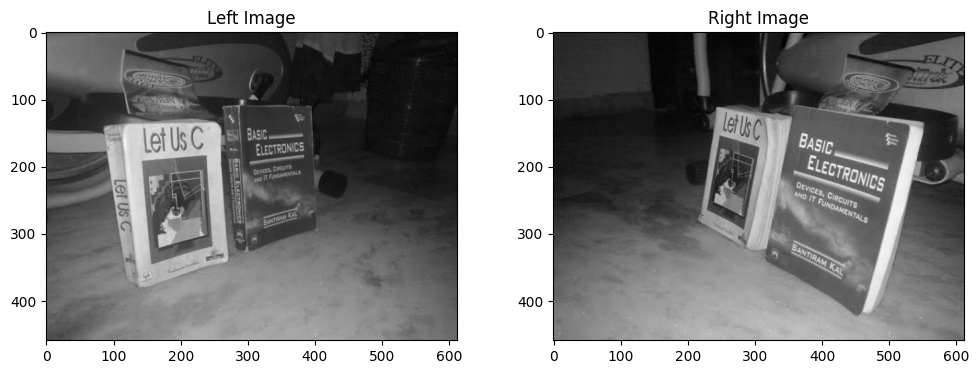

In [8]:
# Load images
img_left = cv2.imread("images/left.jpg", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("images/right.jpg", cv2.IMREAD_GRAYSCALE)

# Display both images
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img_left, cmap='gray')
plt.title("Left Image")
plt.subplot(122)
plt.imshow(img_right, cmap='gray')
plt.title("Right Image")
plt.show()

In [9]:
# Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_left, None)
kp2, des2 = sift.detectAndCompute(img_right, None)

In [10]:
# Match features between left and right images
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

In [11]:
# Apply Lowe’s ratio test to keep only good matches
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print("Number of matched feature points used:", len(pts1))

Number of matched feature points used: 119


In [12]:
# Compute Fundamental Matrix using the 8-point algorithm
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
print("\nFundamental Matrix (F):\n", F)


Fundamental Matrix (F):
 [[ 1.18652420e-05  1.00739962e-04 -4.72274118e-03]
 [-1.43149475e-04  2.82997150e-05  5.54357889e-02]
 [-2.40293238e-03 -5.55271427e-02  1.00000000e+00]]


In [13]:
# Validate the Epipolar Constraint (x2^T * F * x1 ≈ 0)
pts1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
pts2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

print("\nEpipolar Constraint Validation (x2^T * F * x1):")
for i in range(min(10, len(pts1))):  # check first 10 correspondences
    val = np.dot(pts2_h[i], np.dot(F, pts1_h[i]))
    print(f"Point {i+1}: {val:.6f}")


Epipolar Constraint Validation (x2^T * F * x1):
Point 1: -0.390775
Point 2: 2.861733
Point 3: -2.365681
Point 4: 3.826001
Point 5: 1.265837
Point 6: -0.189442
Point 7: -0.926840
Point 8: 0.227855
Point 9: 0.227855
Point 10: 0.227855


In [ ]:
# Visualize Epipolar Lines (Optional)
def drawlines(img1, img2, lines, pts1, pts2):
    """Draw epipolar lines on the first image for points in the second."""
    r, c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2] + r_line[0]*c)/r_line[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(pt2), 5, color, -1)
    return img1_color, img2_color

# Compute epipolar lines for points in the right image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1, 3)

# Draw epipolar lines on the left image
img1_ep, img2_ep = drawlines(img_left, img_right, lines1, pts1, pts2)

cv2.imshow("Left Image with Epipolar Lines", img1_ep)
cv2.imshow("Right Image with Matched Points", img2_ep)
cv2.waitKey(0)
cv2.destroyAllWindows()